# Load Dependencies

In [2]:
import pandas as pd
import itertools,glob
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

from utils.DescriptorProcess import ddG2ee
from utils.DataSelection import cosine_similarity,get_base_index,get_selected_index
%matplotlib notebook
## "max_depth" and "n_estimators" are obtained by hyperparameter optimization.
max_depth = 10
n_estimators = 400
random_seed = 2022

# Define Synthetic Space

The details of the collected dataset

In [3]:
dataset = pd.read_csv('./datasets/dataset.csv',index_col=0)

ddG = dataset['ddG(kcal/mol)'].to_numpy()
ee = dataset['ee'].to_numpy()
dataset

,Biaryl,mole of Biaryl/mmol,Olefin,mole of Olefin/mmol,Product,Catalyst,Catalyst Concentration/%,TDG,TDG Concentration/%,Additive,...,Solvent Ratio,Volume of Solvent/ml,Reaction Time/h,Anode,Cathode,Current(mA),Temperature,Yield,ee,ddG(kcal/mol)
0,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,1.5,60,0.57,0.99,3.507522
1,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,0.0,60,0.20,0.99,3.507522
2,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],5,CC(C)(C)[C@H](N)C(=O)O,10,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,1.5,60,0.38,0.99,3.507522
3,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],5,CC(C)(C)[C@H](N)C(=O)O,10,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,4.0,60,0.33,0.99,3.507522
4,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,2.0,60,0.41,0.99,3.507522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=Cc1ccccc1,0.6,O=Cc1ccccc1-c1c(/C=C/c2ccccc2)ccc2ccccc12,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,16,grahite felt,Pt,1.5,60,0.19,0.86,1.714028
123,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)Oc1ccccc1-c1ccccc1,0.6,O=Cc1ccccc1-c1c(/C=C/C(=O)Oc2ccccc2-c2ccccc2)c...,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,20,grahite felt,Pt,1.0,60,0.55,0.97,2.772852
124,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCC,0.6,CCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,16,grahite felt,Pt,1.5,60,0.55,0.96,2.578852
125,O=Cc1ccc2ccccc2c1-c1ccccc1,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccccc1-c1c(C=O)ccc2ccccc12,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,20,grahite felt,Pt,1.5,60,0.49,0.97,2.772852


Build the synthetic space

In [4]:
biaryl_smiles = dataset['Biaryl'].to_list()
olefin_smiles = dataset['Olefin'].to_list()
tdg_smiles = dataset['TDG'].to_list()
solvent_smiles = dataset['Solvent'].to_list()
additive_smiles = dataset['Additive'].to_list()
current = dataset['Current(mA)'].to_numpy()
temperature = dataset['Temperature'].to_numpy()
additive_smiles = [item if isinstance(item,str) else '' for item in additive_smiles]

biaryl_smi_set = sorted(list(set(biaryl_smiles)))
olefin_smi_set = sorted(list(set(olefin_smiles)))
tdg_smi_set = sorted(list(set(tdg_smiles)))
sol_smi_set = sorted(list(set(solvent_smiles)))
add_smi_set = sorted(list(set(additive_smiles)))
current_set = [1,1.5]
temp_set = [60]

synthetic_space = []
for item in itertools.product(biaryl_smi_set,olefin_smi_set,
    tdg_smi_set,sol_smi_set,add_smi_set,current_set,temp_set):
    synthetic_space.append(item)
synthetic_space_array = np.array(synthetic_space)
synthetic_space = pd.DataFrame.from_records(synthetic_space_array)
synthetic_space.columns = ['Biaryl','Olefin','TDG','Solvent','Additive','Current','Temperature']

print("The size of synthetic space is: %d"%len(synthetic_space))
synthetic_space

The size of synthetic space is: 846720


,Biaryl,Olefin,TDG,Solvent,Additive,Current,Temperature
0,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1,60
1,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1.5,60
2,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1,60
3,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1.5,60
4,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[Na],1,60
...,...,...,...,...,...,...,...
846715,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,O=S(=O)(O[Na])C(F)(F)F,1.5,60
846716,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1,60
846717,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1.5,60
846718,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]O[Cl+3]([O-])([O-])[O-],1,60


# Load descriptors

Load the descriptor dictionary which saves the key-value pairs to transfer the SMILES to physorg descriptors.

The physorg descriptor saved in the dictionary is the encoding with RFECV feature selection. For the details, see notebook 4.

In [5]:
descriptor_map = np.load('./descriptors/descriptor_map_with_RFECV.npz',allow_pickle=True)
biaryl_desc_map = descriptor_map['biaryl'].item()
olefin_desc_map = descriptor_map['olefin'].item()
tdg_desc_map = descriptor_map['tdg'].item()
sol_desc_map = descriptor_map['sol'].item()
add_desc_map = descriptor_map['add'].item()
biaryl_desc_name = descriptor_map['biaryl_name']
olefin_desc_name = descriptor_map['olefin_name']
tdg_desc_name = descriptor_map['tdg_name']
sol_desc_name = descriptor_map['sol_name']
add_desc_name = descriptor_map['add_name']

Generate reaction encodings for the collected dataset.

In [6]:
biaryl_desc = []
olefin_desc = []
tdg_desc = []
add_desc = []
sol_desc = []

for i in range(len(biaryl_smiles)):
    biaryl_desc.append(biaryl_desc_map[biaryl_smiles[i]])
    olefin_desc.append(olefin_desc_map[olefin_smiles[i]])
    tdg_desc.append(tdg_desc_map[tdg_smiles[i]])
    sol_desc.append(sol_desc_map[solvent_smiles[i]])
    add_desc.append(add_desc_map[additive_smiles[i]])

current = (current-current.min())/(current.max()-current.min())

desc = np.concatenate([tdg_desc,olefin_desc,biaryl_desc,
                       sol_desc,add_desc,current.reshape(-1,1)],axis=1).astype(np.float32)
print(desc.shape)

(127, 29)


Generate reaction encodings for the synthetic space.

In [7]:
space_biaryl_desc = []
space_olefin_desc = []
space_tdg_desc = []
space_add_desc = []
space_sol_desc = []
space_current = []
for i in range(len(synthetic_space_array)):
    space_biaryl_desc.append(biaryl_desc_map[synthetic_space_array[i][0]])
    space_olefin_desc.append(olefin_desc_map[synthetic_space_array[i][1]])
    space_tdg_desc.append(tdg_desc_map[synthetic_space_array[i][2]])
    space_sol_desc.append(sol_desc_map[synthetic_space_array[i][3]])
    space_add_desc.append(add_desc_map[synthetic_space_array[i][4]])
    space_current.append(eval(synthetic_space_array[i][5]))
space_current = np.reshape(space_current,(-1,1))
space_current = (space_current-current.min())/(current.max()-current.min())
space_desc = np.concatenate([space_tdg_desc,space_olefin_desc,
                             space_biaryl_desc,
                             space_sol_desc,
                             space_add_desc,
                             space_current],axis=1).astype(np.float32)
print(space_desc.shape)

(846720, 29)


* Principle component analysis is used to extract a subset of the low-dimensional molecular descriptors with the goal of capturing as much information as possible in the high-dimensional structure-enantioselectivity data. 

* Through the principal component analysis, 10 dimensions are selected from the original 29 dimensions of reaction encoding. 

* A subset of original physical organic descriptors is used to speed up the distance calculation, as the distance calculation will be performed 846720 times to extract regional data for the candidate transformations in the entire synthetic space.

* PCA-transformed descriptor is only used in distance calculations.

In [8]:
for i in range(desc.shape[1]):
    pca_sel = PCA(n_components=i,random_state=random_seed)
    desc_sel_pca = pca_sel.fit_transform(desc)
    if pca_sel.explained_variance_ratio_.sum() > 0.9:
        break
desc.shape,desc_sel_pca.shape,pca_sel.explained_variance_ratio_.sum()

((127, 29), (127, 10), 0.90002644)

# Perform Prediction of the Synthetic Space

## Group Points in the Synthetic Space

In [9]:

base_index = get_base_index(desc_sel_pca,threshold=8.5,rand_seed=random_seed)
base_x = desc[base_index]

rest_index = list(set(range(len(desc))) - set(base_index))

rest_x = desc[rest_index]
base_x = desc[base_index]

rest_y = np.array(ddG)[rest_index]
base_y = np.array(ddG)[base_index]

## Divide all points in the synthetic spapce into low confidence group (have no data to perform delta learning) 
## and high confidence group (have enough data to perform delta learning).

low_confidence_point_idx = []

idx2selidx_map = {}   
for idx in range(len(space_desc)):
    point_x = space_desc[idx].reshape(1,-1)
    point_x_sel_pca = pca_sel.transform(point_x)
    rest_x_sel_pca = pca_sel.transform(rest_x)
    sel_idx = get_selected_index(point_x_sel_pca,rest_x_sel_pca,
              method='cosine',threshold=85)
    idx2selidx_map[idx] = sel_idx
    if len(sel_idx) == 0:
        low_confidence_point_idx.append(idx)
        
high_confidence_point_idx = list(set(range(len(space_desc)))-set(low_confidence_point_idx))

## Divide all points into different group by the constitution of 
## the regional dataset to speed up the model training procedure.

selidx2idxs_map = {}           
for idx in high_confidence_point_idx:
    selidx = tuple(idx2selidx_map[idx])
    if not selidx in selidx2idxs_map:
        selidx2idxs_map[selidx] = [idx]
    else:
        selidx2idxs_map[selidx].append(idx)    


/tmp/ipykernel_23431/3639811453.py:21: RuntimeWarning: invalid value encountered in arccos
  diff_deg = np.arccos(np.array([cosine_similarity(rest_react_desc[rand_idx],


In [10]:
print('For holistic prediction of synthetic space, %d times model training will be performed'%len(selidx2idxs_map))

For holistic prediction of synthetic space, 1506 times model training will be performed


## Train $\Delta$-Learning Model and Perform Prediction

In [11]:
k_fold_num = 5

kfold = KFold(n_splits=k_fold_num,shuffle=True,random_state=random_seed)

base_model = ExtraTreesRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                 n_jobs=-1,random_state=random_seed)
val_p = []
val_Y = []
for fit_idx,val_idx in kfold.split(base_x):
    fit_x,fit_y = base_x[fit_idx],base_y[fit_idx]
    val_x,val_y = base_x[val_idx],base_y[val_idx]
    base_model.fit(fit_x,fit_y)
    val_p.append(base_model.predict(val_x))
    val_Y.append(val_y)
val_p = np.concatenate(val_p)
val_y = np.concatenate(val_Y)
base_error = mean_absolute_error(val_y,val_p)
print("The base error is: %.4f"%base_error)

## For low confidence points, the prediction error are base error.
point_error_map = {idx:base_error for idx in low_confidence_point_idx}  

## For low confidence points, predictions are given by base model.
base_model.fit(base_x,base_y)
if len(low_confidence_point_idx) > 0:
    points_x = space_desc[low_confidence_point_idx]
    points_p = base_model.predict(points_x)
    point_pred_map = {idx:points_p[i] for i,idx in enumerate(low_confidence_point_idx)} 
else:
    point_pred_map = {}

delta_model = ExtraTreesRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                 n_jobs=-1,random_state=random_seed)

for j,selidx in enumerate(selidx2idxs_map):

    idxs = selidx2idxs_map[selidx]
    sel_x = rest_x[list(selidx)]
    sel_y = rest_y[list(selidx)]
    
    val_p = []
    val_Y = []
    ## if the regional data is <= k, the prediction of the base model will be used.
    if len(sel_x) > k_fold_num:
        for fit_idx,val_idx in kfold.split(sel_x):
            fit_x,fit_y = sel_x[fit_idx],sel_y[fit_idx]
            val_x,val_y = sel_x[val_idx],sel_y[val_idx]
            fit_p = base_model.predict(fit_x)
            fit_d = fit_y - fit_p
            delta_model.fit(fit_x,fit_d)
            val_p.append(base_model.predict(val_x)+delta_model.predict(val_x))
            val_Y.append(val_y)
        val_p = np.concatenate(val_p)
        val_y = np.concatenate(val_Y)
        error = mean_absolute_error(val_y,val_p)
        if error > base_error:
            for idx in idxs:
                point_error_map[idx] = base_error
            points_x = space_desc[idxs]
            points_p = base_model.predict(points_x)
            for i,idx in enumerate(idxs):
                point_pred_map[idx] = points_p[i]
        else:
            for idx in idxs:
                point_error_map[idx] = error
            sel_p = base_model.predict(sel_x)
            sel_d = sel_y - sel_p
            delta_model.fit(sel_x,sel_d)
            points_x = space_desc[idxs]
            points_p = base_model.predict(points_x) + delta_model.predict(points_x)
            for i,idx in enumerate(idxs):
                point_pred_map[idx] = points_p[i]
    else:
        points_x = space_desc[idxs]
        points_p = base_model.predict(points_x)
        for i,idx in enumerate(idxs):
            point_pred_map[idx] = points_p[i]
            point_error_map[idx] = base_error
    if (j+1) % 500 == 0:
        print("Trained %3d times"%(j+1))

The base error is: 0.2846
Trained 500 times
Trained 1000 times
Trained 1500 times


Get the predicted $\Delta$$\Delta$_G_, _ee_ and corresponding prediction error of every point in the synthetic space. 

In [12]:
all_points_pred_ddG = []
all_points_pred_error = []
for i,item in enumerate(synthetic_space_array):
    all_points_pred_ddG.append(point_pred_map[i]) 
    all_points_pred_error.append(point_error_map[i])
all_points_pred_ee = ddG2ee(np.array(all_points_pred_ddG),273.15+60)

synthetic_space['Predicted_ddG'] = all_points_pred_ddG
synthetic_space['Predicted_ee'] = all_points_pred_ee
synthetic_space['Prediction error'] = all_points_pred_error

synthetic_space

,Biaryl,Olefin,TDG,Solvent,Additive,Current,Temperature,Predicted_ddG,Predicted_ee,Prediction error
0,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1,60,0.290342,0.215643,0.284579
1,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1.5,60,0.290342,0.215643,0.284579
2,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1,60,0.291053,0.216154,0.284579
3,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1.5,60,0.291053,0.216154,0.284579
4,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[Na],1,60,0.290190,0.215533,0.284579
...,...,...,...,...,...,...,...,...,...,...
846715,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,O=S(=O)(O[Na])C(F)(F)F,1.5,60,0.285861,0.212416,0.206591
846716,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1,60,0.375201,0.275784,0.254527
846717,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1.5,60,0.375201,0.275784,0.254527
846718,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,N[C@@H](Cc1cnc[nH]1)C(=O)O,CC(=O)O.OCC(F)(F)F,[Li]O[Cl+3]([O-])([O-])[O-],1,60,0.358425,0.264048,0.206591


Save the prediction results.

In [13]:
synthetic_space.to_csv('./results/synthetic_space_prediction.csv')

# Visualization

## *ee* Distribution of All TDGs

<IPython.core.display.Javascript object>


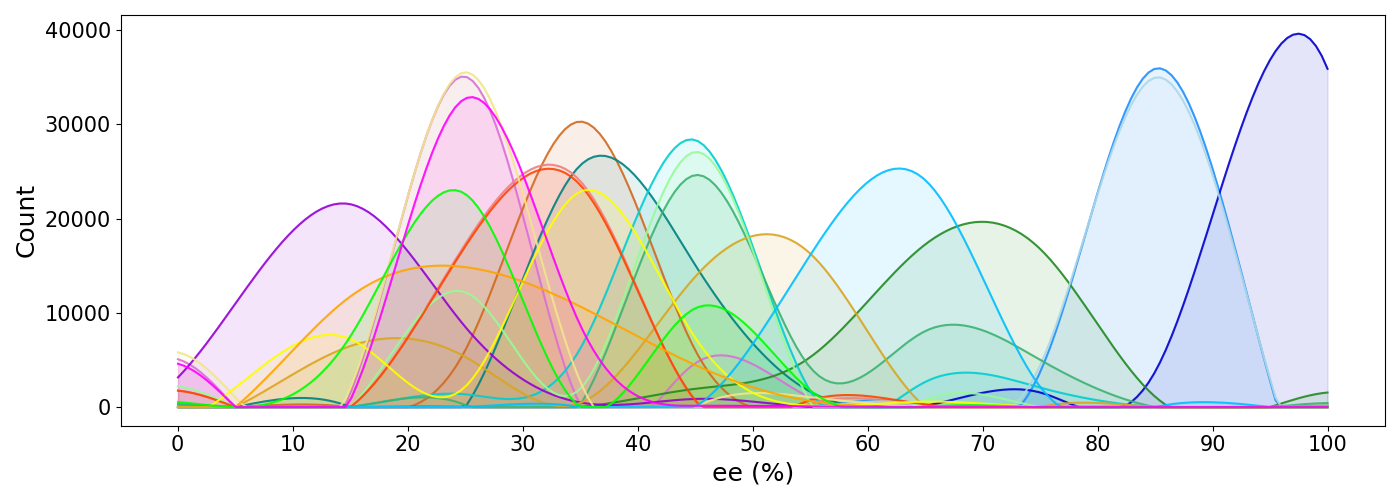

In [14]:
smi_color_map = { 'O=C(O)[C@@H]1CCCN1':'#FFB6C1',   # LightPink
                  'CC(O)[C@H](N)C(=O)O':'#9400D3',   # DarkVoilet
                  'N[C@@H](Cc1cnc[nH]1)C(=O)O':'#FF00FF',  ## Magenta
                  'CC(C)(C)OC(=O)C[C@H](N)C(=O)O':'#DA70D6',  ## Orchid
                  'CC(C)(C)[C@H](NC(=O)[C@@H]([NH3+])c1ccccc1)C(=O)O.[Cl-]':'#F08080',  ##LightCoral
                  'N[C@@H](CC(=O)O)C(=O)O':'#FF4500',  ## OrangeRed
                  'N[C@@H](Cc1ccc(O)cc1)C(=O)O':'#FFA500',  #Orange
                  'CC(C)(C)[C@H](NC(=O)C[NH3+])C(=O)O.[Cl-]':'#D2691E', # Chocolate
                  'N[C@@H](CCC(=O)O)C(=O)O':'#F0E68C',  # Khaki
                  'N[C@@H](CO)C(=O)O':'#FFFF00',  ## Yellow
                  'N=C(N)NCCC[C@H](N)C(=O)O':'#DAA520',  ## GoldEnrod
                  'N[C@@H](C(=O)O)c1ccccc1':'#98FB98',  ## PaleGreen
                  'N[C@@H](Cc1ccccc1)C(=O)O':'#00FF00',  ## Lime
                  'CC[C@H](C)[C@H](N)C(=O)O':'#3CB371',  ## SpringGreen
                  'CC(C)(C)[C@H]([NH3+])C(=O)N[C@H](C(=O)O)C(C)(C)C.[Cl-]':'#228B22',  ## ForestGreen
                  'CC(C)[C@H](N)C(=O)O':'#00CED1',  #DarkTurquoise
                  'CC(C)(C)[C@H](NC(=O)[C@@H]([NH3+])Cc1ccccc1)C(=O)O.[Cl-]':'#008080', #Teal
                  'CC(C)[C@H](NC(=O)[C@@H]([NH3+])C(C)(C)C)C(=O)O.[Cl-]':'#ADD8E6',  ##LightBLue
                  'N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O':'#00BFFF',  ## DeepSkyBlue
                  'CC(C)(C)[C@H](N)C(=O)N[C@H](C(=O)O)C(C)(C)C':'#1E90FF',  ##DoderBlue
                  'CC(C)(C)[C@H](N)C(=O)O':'#0000CD', ## MediumBlue
                 }

tdg_smi_count_map = {}

for tdg_smi in tdg_smi_set:
    tdg_smi_count_map[tdg_smi] = {0:0,0.1:0,0.2:0,0.3:0,0.4:0,0.5:0,
                              0.6:0,0.7:0,0.8:0,0.9:0,1:0,1.1:0}

for i,item in enumerate(synthetic_space_array):
    tmp_tdg_smi = item[2]
    tmp_ee = all_points_pred_ee[i]
    tmp_ddG = all_points_pred_ddG[i]
    tmp_error = all_points_pred_error[i]

    
    for key in tdg_smi_count_map[tmp_tdg_smi]:
        if tmp_ee < key:
            tdg_smi_count_map[tmp_tdg_smi][key] += 1
            break

sorted_tdg_smi_list = [item[1] for item in sorted([[int(sum([item*tdg_smi_count_map[key][item] \
                       for item in tdg_smi_count_map[key]])),key] \
                       for key in tdg_smi_count_map],key=lambda x:x[0],reverse=True)]

plt.figure(figsize=(14,5))
x = np.array([-5,5,15,25,35,45,55,65,75,85,95,105])
for idx,smi in enumerate(tdg_smi_set):
    y = np.array([tdg_smi_count_map[smi][key] for key in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]])

    x_smooth = np.linspace(x.min(), x.max(), 220)[10:-10]
    y_smooth = make_interp_spline(x, y)(x_smooth)
    y_smooth = np.where(y_smooth>0,y_smooth,0)


    plt.plot(x_smooth, y_smooth,c=smi_color_map[smi],alpha=0.9)
    plt.fill_between(x_smooth,y_smooth,np.zeros(len(y_smooth)),color=smi_color_map[smi],alpha=0.1)
        
plt.xticks([0,10,20,30,40,50,60,70,80,90,100],['0','10','20','30','40','50',
                                             '60','70','80','90','100'],fontsize=15)
plt.yticks([0,10000,20000,30000,40000],['0','10000','20000','30000','40000'],fontsize=15)
plt.xlabel('ee (%)',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()
print()    

## *ee* Distribution of the Combination of Biaryl and TDG in the Training Set

In [15]:
all_train_biaryl_tdg_map = {}
for i in range(len(biaryl_smiles)):
    pair = '%s+%s'%(biaryl_smiles[i],tdg_smiles[i])
    if not pair in all_train_biaryl_tdg_map:
        all_train_biaryl_tdg_map[pair] = [ee[i]]
    else:
        all_train_biaryl_tdg_map[pair].append(ee[i])
all_pred_biaryl_tdg_map = {}
for i in range(len(synthetic_space_array)):
    pair = '%s+%s'%(synthetic_space_array[i][0],synthetic_space_array[i][2])
    if pair in all_train_biaryl_tdg_map:
        if not pair in all_pred_biaryl_tdg_map:
            all_pred_biaryl_tdg_map[pair] = [all_points_pred_ee[i]]
        else:
            all_pred_biaryl_tdg_map[pair].append(all_points_pred_ee[i])
    

As there are many randomness, the predictions are not exactly same for the every time. However, the range of the predicted *ee* is always exceed the observed *ee* in the training set.

In [16]:
print('{0:^40} {1:^60} {2:^12} {3:^8}'.format('Biaryl','TDG','Obs. ee','Pred. ee'))
for pair in all_train_biaryl_tdg_map:
    print('{0:^40} {1:^60}'.format(pair.split('+')[0],'+'.join(pair.split('+')[1:])),
          '%.2f - %.2f %.2f - %.2f'%(min(all_train_biaryl_tdg_map[pair]),max(all_train_biaryl_tdg_map[pair]),
                                    min(all_pred_biaryl_tdg_map[pair]),max(all_pred_biaryl_tdg_map[pair])))

                 Biaryl                                              TDG                                Obs. ee    Pred. ee
       O=Cc1ccccc1-c1cccc2ccccc12                           CC(C)(C)[C@H](N)C(=O)O                    0.40 - 0.99 0.66 - 1.00
       O=Cc1ccccc1-c1cccc2ccccc12                          N[C@@H](C(=O)O)c1ccccc1                    0.40 - 0.42 0.21 - 0.66
       O=Cc1ccccc1-c1cccc2ccccc12                CC(C)(C)[C@H](N)C(=O)N[C@H](C(=O)O)C(C)(C)C          0.89 - 0.89 0.73 - 0.94
       O=Cc1ccccc1-c1cccc2ccccc12                         N[C@@H](Cc1cnc[nH]1)C(=O)O                  0.24 - 0.24 0.19 - 0.50
       O=Cc1ccccc1-c1cccc2ccccc12                          N=C(N)NCCC[C@H](N)C(=O)O                   0.12 - 0.55 0.13 - 0.56
       O=Cc1ccccc1-c1cccc2ccccc12                             N[C@@H](CO)C(=O)O                       0.06 - 0.42 0.08 - 0.61
       O=Cc1ccccc1-c1cccc2ccccc12                            CC(C)[C@H](N)C(=O)O                      0.46 - 0.48 0.22 -

# Validate the Experimental Results

In [17]:
space_val_set = pd.read_csv('./datasets/space_validation_set.csv',index_col=0)

space_val_re1_smi = space_val_set['Biaryl'].to_list()
space_val_re2_smi = space_val_set['Olefin'].to_list()
space_val_lig_smi = space_val_set['Ligand'].to_list()
space_val_add_smi = space_val_set['Additive'].to_list()
space_val_add_smi = [item if isinstance(item,str) else '' for item in space_val_add_smi]
space_val_sol_smi = space_val_set['Solvent'].to_list()
space_val_current = space_val_set['Current'].to_list()
space_val_temp = space_val_set['Temperature'].to_list()
space_val_ddG = space_val_set['ddG'].to_list()
space_val_ee = space_val_set['ee'].to_list()

In [18]:
idx_in_space = []
for i in range(len(space_val_re1_smi)):
    for idx,item in enumerate(synthetic_space_array):
        if item[0] == space_val_re1_smi[i] and item[1] == space_val_re2_smi[i] and\
        item[2] == space_val_lig_smi[i] and item[3] == space_val_sol_smi[i] and\
        item[4] == space_val_add_smi[i] and eval(item[5]) == space_val_current[i] and\
        eval(item[6]) == space_val_temp[i]:
            idx_in_space.append(idx)
            break
val_space_x = space_desc[idx_in_space]
val_space_y = np.array(space_val_ddG)

In [23]:
k_fold_num = 5

base_index = get_base_index(desc_sel_pca,threshold=8.5,rand_seed=random_seed)  ## the index of the dataset used to train base model
base_x = desc[base_index]

rest_index = list(set(range(len(desc))) - set(base_index))

rest_x = desc[rest_index]
base_x = desc[base_index]

rest_y = np.array(ddG)[rest_index]
base_y = np.array(ddG)[base_index]

kfold = KFold(n_splits=k_fold_num,shuffle=True,random_state=random_seed)

base_model = ExtraTreesRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                 n_jobs=-1,random_state=random_seed)
val_p = []
val_Y = []
for fit_idx,val_idx in kfold.split(base_x):
    fit_x,fit_y = base_x[fit_idx],base_y[fit_idx]
    val_x,val_y = base_x[val_idx],base_y[val_idx]
    base_model.fit(fit_x,fit_y)
    val_p.append(base_model.predict(val_x))
    val_Y.append(val_y)
val_p = np.concatenate(val_p)
val_y = np.concatenate(val_Y)
base_error = mean_absolute_error(val_y,val_p)
print("Base Error: %.4f"%base_error)
base_model.fit(base_x,base_y)


delta_model = ExtraTreesRegressor(n_estimators=n_estimators,max_depth=max_depth,
                             n_jobs=-1,random_state=random_seed)
points_p = []
points_error = []

for j,idx in enumerate(idx_in_space):
    point_x = space_desc[idx].reshape(1,-1)
    point_x_sel_pca = pca_sel.transform(point_x)    
    rest_x_sel_pca = pca_sel.transform(rest_x)
    sel_idx = get_selected_index(point_x_sel_pca,rest_x_sel_pca,method='cosine',threshold=85)

    sel_x = rest_x[list(sel_idx)]
    sel_y = rest_y[list(sel_idx)]
    val_p = []
    val_Y = []
    if len(sel_x) > k_fold_num:
        for fit_idx,val_idx in kfold.split(sel_x):
            fit_x,fit_y = sel_x[fit_idx],sel_y[fit_idx]
            val_x,val_y = sel_x[val_idx],sel_y[val_idx]
            fit_p = base_model.predict(fit_x)
            fit_d = fit_y - fit_p
            delta_model.fit(fit_x,fit_d)
            val_p.append(base_model.predict(val_x)+delta_model.predict(val_x))
            val_Y.append(val_y)
        val_p = np.concatenate(val_p)
        val_y = np.concatenate(val_Y)
        error = mean_absolute_error(val_y,val_p)
        if error > base_error:
            point_p = base_model.predict(point_x)
            points_p.append(point_p)
            points_error.append(base_error)
            
        else:
            sel_p = base_model.predict(sel_x)
            sel_d = sel_y - sel_p
            delta_model.fit(sel_x,sel_d)
            point_p = base_model.predict(point_x)+delta_model.predict(point_x)
            points_p.append(point_p)
            points_error.append(error)

    else:
        point_p = base_model.predict(point_x)
        points_p.append(point_p)
        points_error.append(base_error)

points_error_ave = np.mean(points_error)
points_p = np.concatenate(points_p)
std_e = mean_absolute_error(np.array(space_val_ddG),points_p)
r2 = r2_score(np.array(space_val_ddG),points_p)

/tmp/ipykernel_23431/3639811453.py:21: RuntimeWarning: invalid value encountered in arccos
  diff_deg = np.arccos(np.array([cosine_similarity(rest_react_desc[rand_idx],


Base Error: 0.2846


<IPython.core.display.Javascript object>


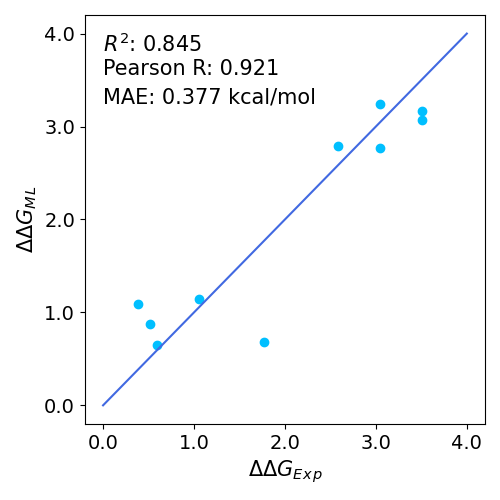

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(space_val_ddG,points_p,c='deepskyblue')


plt.text(0,3.8,'$R^2$: %.3f'%r2_score(space_val_ddG,points_p),fontsize=15)
plt.text(0,3.55,'Pearson R: %.3f'%pearsonr(space_val_ddG,points_p)[0],fontsize=15)
plt.text(0,3.25,'MAE: %.3f kcal/mol'%mean_absolute_error(space_val_ddG,points_p),fontsize=15)

plt.plot([0,4],[0,4],c='royalblue')
plt.xticks([0,1,2,3,4],['0.0','1.0','2.0','3.0','4.0'],fontsize=14)
plt.yticks([0,1,2,3,4],['0.0','1.0','2.0','3.0','4.0'],fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$',fontsize=15)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

# Visualization with t-SNE

Size of base set: 57, size of delta set: 45
predicted ddG: 1.051, observed ddG: 1.149, error of prediction: 0.263


<IPython.core.display.Javascript object>


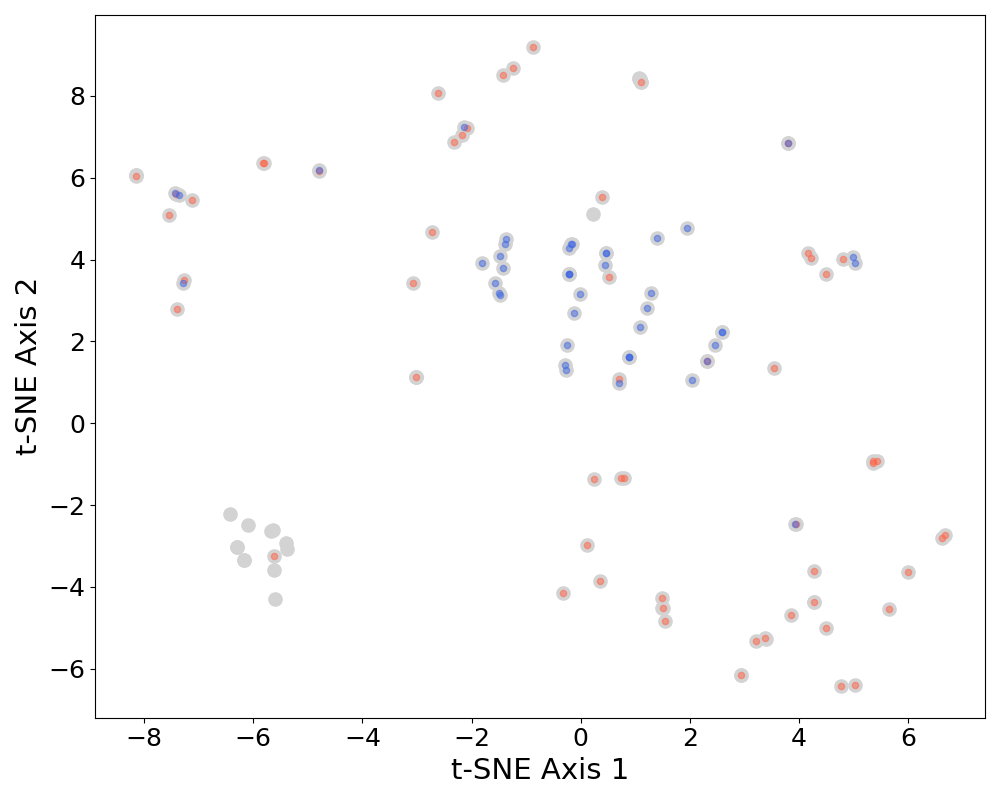

In [25]:

idx = 7   ## select a data point in the experimental results for visualization
i = idx_in_space[idx]

base_x = desc[base_index]
rest_index = list(set(range(len(desc))) - set(base_index))

rest_x = desc[rest_index]
rest_y = np.array(ddG)[rest_index]

np.random.seed(random_seed)
tsne = TSNE(n_components=2)

train_x_tsne = tsne.fit_transform(desc)
base_x_tsne = train_x_tsne[base_index]
rest_x_tsne = train_x_tsne[rest_index]


point_x = space_desc[i].reshape(1,-1)
point_x_sel_pca = pca_sel.transform(point_x)
rest_x_sel_pca = pca_sel.transform(rest_x)
sel_idx = get_selected_index(point_x_sel_pca,rest_x_sel_pca,method='cosine',threshold=85)
sel_x_tsne = rest_x_tsne[list(sel_idx)]
print('Size of base set: %d, size of delta set: %d'%(len(base_x_tsne),len(sel_x_tsne)))
print('predicted ddG: %.3f, observed ddG: %.3f, error of prediction: %.3f'%(np.array(space_val_ddG)[idx],
                                                                      points_p[idx],points_error[idx]))
plt.figure(figsize=(10,8))
plt.scatter(train_x_tsne[:,0],train_x_tsne[:,1],c='lightgray',s=90)
plt.scatter(base_x_tsne[:,0],base_x_tsne[:,1],c='tomato',alpha=0.5,s=20)
plt.scatter(sel_x_tsne[:,0],sel_x_tsne[:,1],c='royalblue',alpha=0.5,s=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('t-SNE Axis 1',fontsize=21)
plt.ylabel('t-SNE Axis 2',fontsize=21)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

